# Lab 06: Técnicas de Optimización de Entrenamientos

Realizado por: Hugo Cordoba Leal

## 0. Librerías

In [136]:
import pandas as pd
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import time


## 1. Carga de datos y procesamiento de los mismos

In [137]:
# Cargar los datos
data = pd.read_csv("IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [138]:
# Limpiar el texto
def clean_text(text):
    # Eliminar etiquetas HTML
    text = re.sub(r'<.*?>', '', text)
    # Convertir texto a minúsculas
    text = text.lower()
    # Eliminar caracteres no alfabéticos y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Aplicar la función de limpieza al conjunto de datos
data['review'] = data['review'].apply(clean_text)

# Mostrar los primeros registros para verificar
data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


In [139]:
# Mostrar el número de filas con valores nulos en las columnas 'label' o 'text'
print('Filas con valores nulos en el dataset:')
print(data[['review','sentiment']].isnull().sum())

# Eliminar filas con valores nulos
data = data.dropna(subset=['review','sentiment'])

Filas con valores nulos en el dataset:
review       0
sentiment    0
dtype: int64


## 2. Preparamos el entrenamiento

In [140]:
# Filtrar el dataset para que solo contenga las clases 'Positive' y 'Negative'
data = data[data['sentiment'].isin(['positive', 'negative'])]

# Mapear las etiquetas a valores numéricos
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})  # Binary encoding

# Asignamos la variable a predecir 'label' como 'y'
y = data['sentiment'].values  # Ensure y is a numpy array of numerical type
print(y)

[1 1 1 ... 0 0 0]


In [141]:
# Tokenizamos los textos y los convertimos a secuencias (asignamos X)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['review'].values)
sequences = tokenizer.texts_to_sequences(data['review'].values)
X = pad_sequences(sequences, maxlen=100)

# Dividir en train y validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Preprocessed text:', data['review'].values[100])
print('\nTokenized text:', sequences[100])
print('\nPadded text:', X[100])
print('\nPadded text Length: ', len(X[100]))

# 3. Entreamiento del modelo

In [ ]:
# Definir la matriz de embeddings (en este caso, una matriz de ceros)
embedding_size = 100  # Dimensión de los embeddings
vocab_size = len(tokenizer.word_index) + 1  # Tamaño del vocabulario

# Construir el modelo de red neuronal
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=100),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar el resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          21566000  
                                                                 
 flatten_4 (Flatten)         (None, 10000)             0         
                                                                 
 dense_20 (Dense)            (None, 128)               1280128   
                                                                 
 dense_21 (Dense)            (None, 1)                 129       
                                                                 
Total params: 22846257 (87.15 MB)
Trainable params: 22846257 (87.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
313/313 [==============================] - 32s 102ms/step - loss: 0.4207 - accuracy: 0.7938 - val_loss: 0.3281 - val_accuracy: 0.8562

# 4. Prueba del modelo

In [ ]:
# Función para preprocesar una sola reseña
def preprocess_review(review):
    cleaned_review = clean_text(review)  # Limpiar el texto
    sequence = tokenizer.texts_to_sequences([cleaned_review])  # Convertir a secuencia
    padded_sequence = pad_sequences(sequence, maxlen=100)  # Añadir padding
    return padded_sequence

# Reseña de prueba
review = "This movie was not incredible! I hated a minute of it."

# Preprocesar la reseña
processed_review = preprocess_review(review)

# Predecir la polaridad de la reseña utilizando el modelo
prediction = model.predict(processed_review)

# Imprimir la predicción
if prediction > 0.5:
    print("La reseña es positiva.")
else:
    print("La reseña es negativa.")


1/1 [==============================] - 0s 231ms/step
La reseña es negativa.


# 5. Optimización del modelo

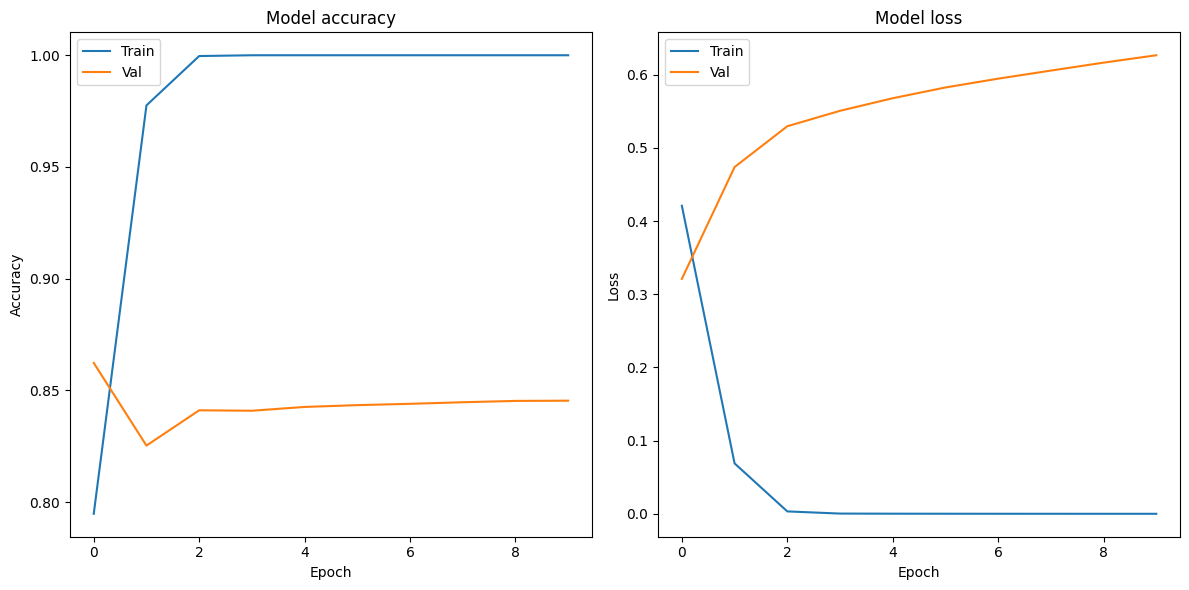

In [ ]:
# Assuming 'history' is the result of fitting your model
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

**Batch Sizes**

En mi caso, como tamano de batch he elegido 128 porque me ofrece un buen equilibrio entre la eficiencia computacional y la capacidad de generalización. Los tamaños de lote en este rango pueden aprovechar eficientemente las capacidades de hardware modernas (como GPUs), al tiempo que mantienen el ruido en el entrenamiento a un nivel que puede ser beneficioso para escapar de mínimos locales.  

In [ ]:
# Ejemplo de entrenamiento del modelo y guardado del historial
start_time = time.time()
history_ffnn_batch_64 = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), verbose=0)
end_time = time.time()
duration = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento con batch 64: {round(duration,2)} segundos")

start_time = time.time()
history_ffnn_batch_128 = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_val, y_val), verbose=0)
end_time = time.time()
duration = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento con batch 128: {round(duration,2)} segundos")

start_time = time.time()
history_ffnn_batch_256 = model.fit(X_train, y_train, epochs=5, batch_size=256, validation_data=(X_val, y_val), verbose=0)
end_time = time.time()
duration = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento con batch 256: {round(duration,2)} segundos")

start_time = time.time()
history_ffnn_batch_512 = model.fit(X_train, y_train, epochs=5, batch_size=512, validation_data=(X_val, y_val), verbose=0)
end_time = time.time()
duration = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento con batch 512: {round(duration,2)} segundos")

Tiempo de ejecución del entrenamiento con batch 64: 187.67 segundos
Tiempo de ejecución del entrenamiento con batch 128: 114.96 segundos
Tiempo de ejecución del entrenamiento con batch 256: 47.44 segundos
Tiempo de ejecución del entrenamiento con batch 512: 25.24 segundos


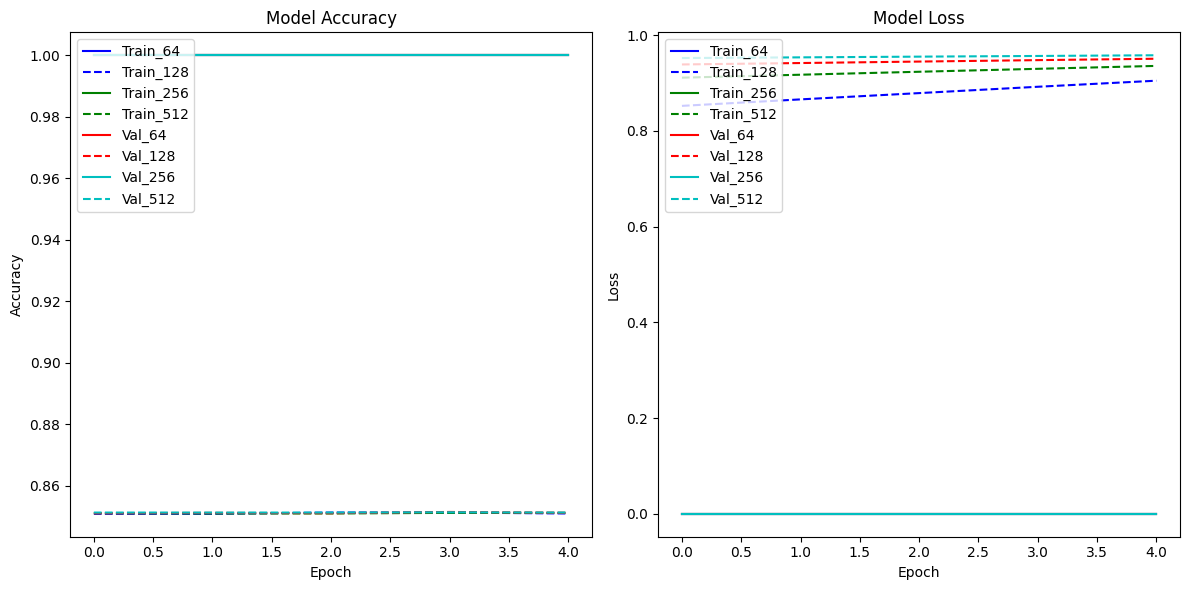

In [ ]:
# Colores distintivos para cada grupo de tamaño de lote
colors = ['b', 'g', 'r', 'c']
labels = ['64', '128', '256', '512']

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
for i, history in enumerate([history_ffnn_batch_64.history, history_ffnn_batch_128.history, history_ffnn_batch_256.history, history_ffnn_batch_512.history]):
    plt.plot(history['accuracy'], color=colors[i], linestyle='-')
    plt.plot(history['val_accuracy'], color=colors[i], linestyle='--')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend([f'Train_{l}' for l in labels] + [f'Val_{l}' for l in labels], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
for i, history in enumerate([history_ffnn_batch_64.history, history_ffnn_batch_128.history, history_ffnn_batch_256.history, history_ffnn_batch_512.history]):
    plt.plot(history['loss'], color=colors[i], linestyle='-')
    plt.plot(history['val_loss'], color=colors[i], linestyle='--')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend([f'Train_{l}' for l in labels] + [f'Val_{l}' for l in labels], loc='upper left')

plt.tight_layout()
plt.show()

**Optimizador**

Como optimizador he elegido ADAM (Adaptive Moment Estimation). He seleccionado ADAM, por varias razones: adaptabilidad del learning rate, eficiencia computacional, tiene pocos hiperparámetros para ajustar y una amplia aceptación y uso en la comunidad, siempre viene bien para buscar informacion al respecto